---

# Forth (hypotetical) Hands-On Session

- Energy effects: intruducing dispersion

---

In [ ]:
# Import custom tracking functions and useful libraries
from tracking_library import *

# Set up plotting
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

### Exercise 33 (guided)
Upgrade the software to consistently handle $3\times3$ matrices for drift space, quadrupoles, and sector dipoles, where the third coordinate corresponds to the particle energy deviation $\mathrm{d}p/p_0$.

#### SOLUTION 

In [11]:
from tracking_library_advanced_solution import D3
from tracking_library_advanced_solution import Q3
from tracking_library_advanced_solution import B3


### Exercise 34
Build a beam line of six FODO cells with a phase advance of 60 degrees/cell (thin quadrupoles are OK to use) and add a sector bending magnet with length 1 m and bending angle $\phi=10$ degrees in the center of each drift. You may have to play with the quadrupole values to make the phase advance close to 60 degrees. But you probably already did this in Exercise 32.

#### SOLUTION

In [13]:
f = 2.26085
l_cell = 4
l_dipole = 1
l_drift = (l_cell-l_dipole*2)/4
phi = 20*np.pi/360
fodo_lattice = Q3(f) + 3*D3(l_drift/3) + B3(phi,l_dipole) + 3*D3(l_drift/3) + \
               Q3(-f) + 3*D3(l_drift/3) + B3(phi,l_dipole) + 3*D3(l_drift/3)

tune, beta, alpha, gamma = twiss(fodo_lattice)
print(f'''
The tune is: {tune}
The beta is: {beta} m
The alpha is: {alpha} 
The gamma is: {gamma}
''')


The tune is: 0.16666742254599543
The beta is: 6.402756913976354 m
The alpha is: -1.4160065714170231 
The gamma is: 0.4693407309805126



### Exercise 35
Use the starting conditions $(x_0,x_0',\delta)=(0,0,0)$ and plot the position along the beam line. Repeat this for $\delta=10^{-3}$ and for $\delta=3\times 10^{-3}$. Plot all three traces in the same graph. Discuss what you observe and explain.

#### SOLUTION

Text(0, 0.5, 'x [mm]')

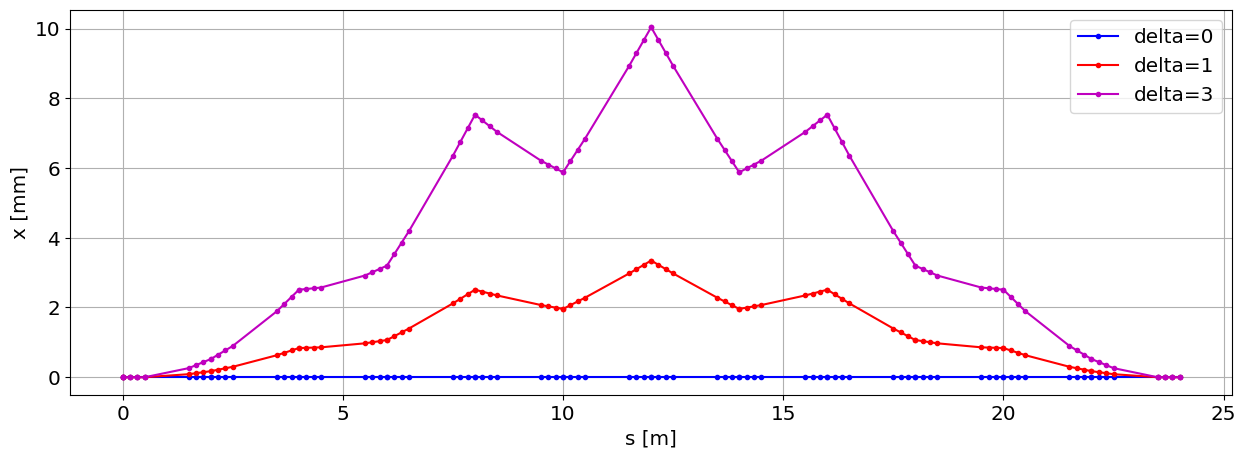

In [14]:
# tracking
for delta,color in zip([0,1, 3],['b','r','m']):
    beam = np.array([[0],[0],[delta]])
    transported_particles = transportParticles(beam, 6*fodo_lattice)
    plt.plot(transported_particles['s'], transported_particles['x'], '.-'+color, label=f'delta={delta}')

plt.legend()
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('x [mm]')

### Exercise 36
Work out the transverse components of the periodic beam matrix $\sigma_0$. Assume that the geometrical emittance is $\epsilon_0=10^{-6}$ m rad. Furthermore, assume that the momentum spread $\sigma_0(3,3)=\sigma_p^2$ is zero and plot the beam size along the beam line.

#### SOLUTION

In [15]:
epsilon_0 = 1e-6
sigma_p_2 = 0
sigma_0 = epsilon_0*np.array([[beta, -alpha, 0],[-alpha, gamma,0],[0,0,sigma_p_2]])

Text(0.5, 0, 's [m]')

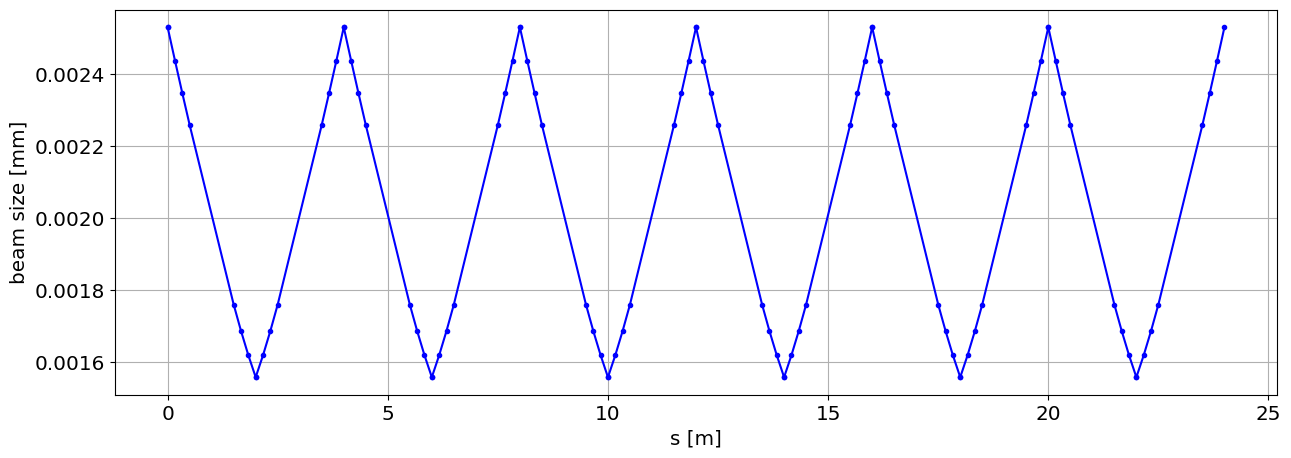

In [16]:
transported_sigmas = transportSigmas(sigma_0, 6*fodo_lattice)
plt.plot(transported_sigmas['s'], np.sqrt(transported_sigmas['sigma11']), '.-b')
plt.grid(True)
plt.ylabel('beam size [mm]')
plt.xlabel('s [m]')

### Exercise 37
Plot the beam size for for $\sigma_p^2=10^{-3}$ and for $\sigma_p^2=3\times 10^{-3}$. What happens if you change the phase advance of the cell? Try out by slightly changing the focal lengths.

#### SOLUTION

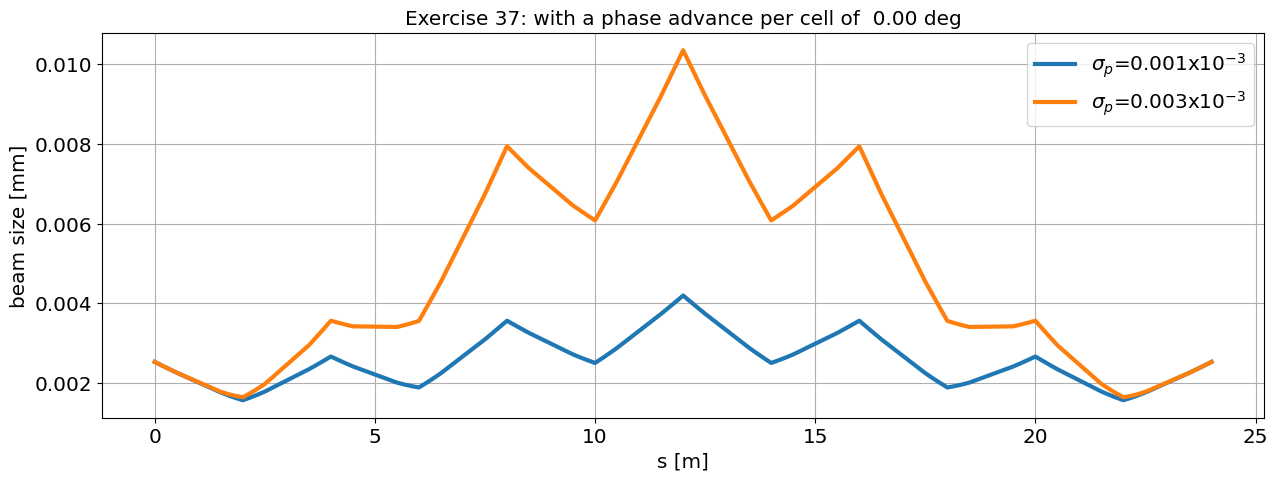

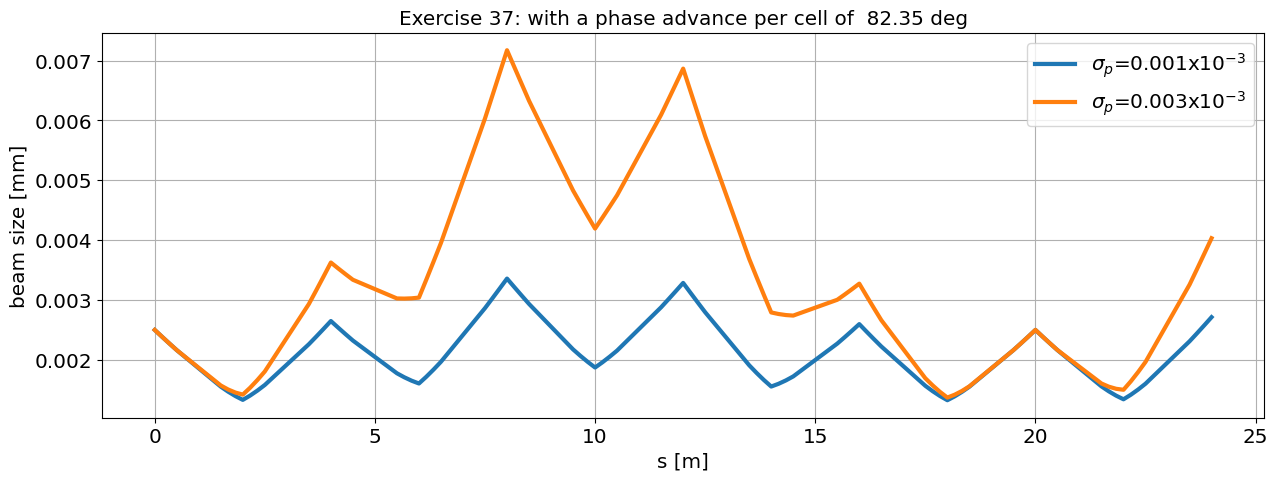

In [17]:
l_cell = 4
l_dipole = 1
l_drift = (l_cell-l_dipole*2)/4
phi = 20*np.pi/360

for f in [2.26085, 1.8]:
    plt.figure()
    fodo_lattice = Q3(f)+3*D3(l_drift/3)+B3(phi,l_dipole)+3*D3(l_drift/3)+Q3(-f)+3*D3(l_drift/3)+B3(phi,l_dipole)+3*D3(l_drift/3)
    beamline = 6*fodo_lattice
    tune, beta, alpha, gamma = twiss(beamline)
    
    for sigma_p in [1e-3, 3e-3]:
        sigma_p_2 = (sigma_p)**2
        sigma_0 = epsilon_0*np.array([[beta, -alpha, 0],[-alpha, gamma,0],[0,0,sigma_p_2/epsilon_0]])
        transported_sigmas = transportSigmas(sigma_0, 6*fodo_lattice)
        plt.plot(transported_sigmas['s'], np.sqrt(transported_sigmas['sigma11']), label= f'$\sigma_p$={sigma_p}x$10^{{-3}}$', lw=3)

    plt.grid(True)
    plt.ylabel('beam size [mm]')
    plt.xlabel('s [m]')
    plt.title(f'Exercise 37: with a phase advance per cell of {tune*2*180: 3.2f} deg')
    plt.legend(loc='best')

### Exercise 38

Determine the periodic dispersion at the start of the cell. Then plot the dispersion in the cell.

#### SOLUTION

For that we need to find the *real* periodic solution of the 3x3 one turn matrix

In [18]:
OTM = getEquivalentElement(beamline)
eigenvalues, eigenvectors =np.linalg.eig(OTM[0]['matrix'])
print(eigenvalues)
print(eigenvectors[:,2])

[0.13306447+0.99110738j 0.13306447-0.99110738j 1.        +0.j        ]
[0.75524936+0.j 0.20979149+0.j 0.62095567+0.j]


Note that the third eigenvalue is real, i.e. is associated to a real eigenvector, which is our solution:

In [19]:
myDispersion=np.real(eigenvectors[:,2]/eigenvectors[2,2])
print(myDispersion)

[1.21626937 0.3378526  1.        ]


Sanity check: one can see that indeeed is a periodic solution!

In [20]:
OTM[0]['matrix'] @ myDispersion

array([1.21626937, 0.3378526 , 1.        ])

And track it along our lattice:

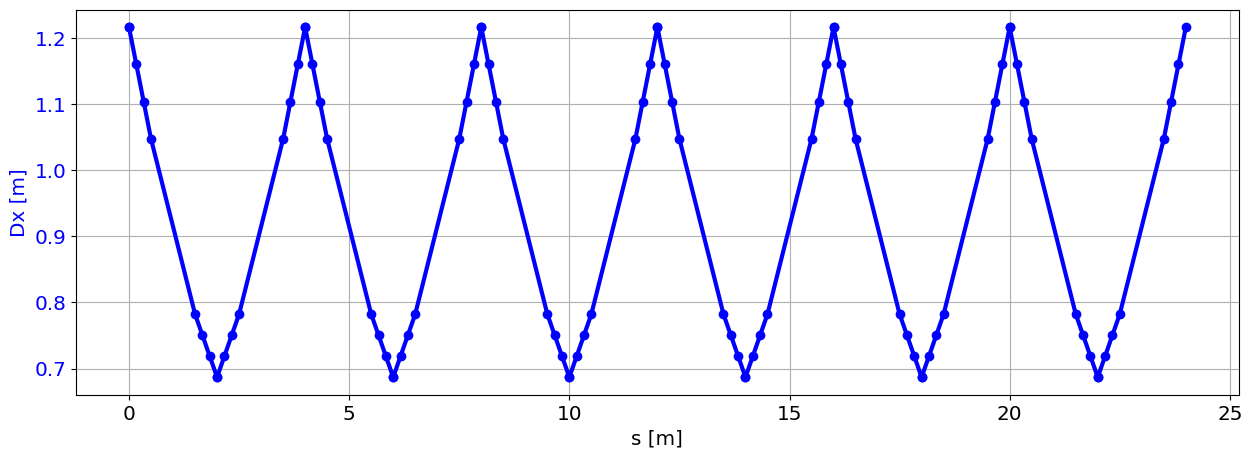

In [21]:
# need to make dispersion array compatible with our transportParticles function
myDispersion = np.reshape(myDispersion, (3,1))
transported_particles = transportParticles(myDispersion, beamline)

plt.plot(transported_particles['s'], transported_particles['x'], 'o-b', lw=3)
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('Dx [m]', color='b')
plt.tick_params(axis='y', labelcolor='b')
